![Alt text](pic.png)

In [6]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

def estimate_m_values(data, strain_rate_columns, strain_rates, temp, plot=True):
    """
    Estimate m values for each strain by fitting a linear regression to log-log data and visualize the results.
    """
    m_values = []
    
    for i in range(len(data)):
        # Extract stress values for different strain rates for the current row
        stress_values = data.iloc[i][strain_rate_columns].values
        
        # Apply log transformation to stress and strain rates
        log_stress = np.log(stress_values)
        log_strain_rates = np.log(strain_rates / 0.0001).reshape(-1, 1)
        
        # Linear regression with intercept set to zero
        model = LinearRegression(fit_intercept=False)
        model.fit(log_strain_rates, log_stress)
        
        # Get the slope (m value)
        slope = model.coef_[0]
                
        # Append the estimated m and corresponding strain
        m_values.append({
            'strain': data['strain'].iloc[i],
            'm_estimated': slope
        })
    
    # Convert m_values to a DataFrame
    df = pd.DataFrame(m_values)
    
    if plot:
        # Plotting real vs predicted stress for each strain rate
        strain = data['strain']
        for strain_rate, col in zip(strain_rates, strain_rate_columns):
            # Calculate predicted stress using evolving m for each strain
            fitted_stress = [(strain_rate / 0.0001) ** m for m in df['m_estimated']]
            real_stress = data[col]
            
            # Plot the predicted and real stress values
            plt.plot(strain, fitted_stress, label=f'Predicted StrRt{strain_rate}')
            plt.scatter(strain, real_stress, color='red', label=f'Real StrRt{strain_rate}')
            plt.xlabel('Strain')
            plt.ylabel('Normalized Stress')
            plt.title(f'Real vs Predicted Stress for StrRt{strain_rate} {temp}K')
            plt.legend()
            plt.show()
    
    # Save m values to a CSV
    df.to_csv(f'pl_m_values_{temp}.csv', index=False)
    return df

def fit_m_function(m_values_df):
    """
    Fit the function m(strain) to the estimated m values to find a, b, c, d, e.
    """
    # Define the m function
    def m_function(strain, a,b,c,d,e):
        epsilon = 1e-10  # A very small positive value
        return a * (strain + epsilon)**b
    
    # Perform curve fitting
    params, _ = curve_fit(
        m_function,
        m_values_df['strain'],
        m_values_df['m_estimated'],
        #p0=[0.001, -0.5],  # Initial guess for [a, b, c, d, e]
        #bounds=([1e-5, -0.9], [10, 0.9]), # Lower and upper bounds for [a, b, c]
        maxfev=100000
    )

    m_values_df['fitted_m'] = m_function(m_values_df['strain'], *params)

    plt.title(f'Fitted vs estimated m values')
    plt.scatter(m_values_df['strain'], m_values_df['m_estimated'], label='Estimated m values', color='red')
    plt.plot(m_values_df['strain'], m_values_df['fitted_m'], label='Fitted m function', color='blue')
    plt.xlabel('Strain')
    plt.ylabel('Estimated m')
    plt.legend()
    plt.show()
    plt.show()

    return m_values_df

def validate_stress(m_values_df, data, strain_rate_columns, strain_rates):
    # Plotting real vs predicted stress for each strain rate
    strain = data['strain']
    for strain_rate, col in zip(strain_rates, strain_rate_columns):
        # Calculate predicted stress using evolving m for each strain
        fitted_stress = [(strain_rate / 0.0001) ** m for m in m_values_df['fitted_m']]
        real_stress = data[col]
        
        # Plot the predicted and real stress values
        plt.plot(strain, fitted_stress, label=f'Predicted StrRt{strain_rate}')
        plt.scatter(strain, real_stress, color='red', label=f'Real StrRt{strain_rate}')
        plt.xlabel('Strain')
        plt.ylabel('Normalized Stress')
        plt.title(f'Validate real vs Predicted Stress for StrRt {strain_rate}')
        plt.legend()
        plt.show()


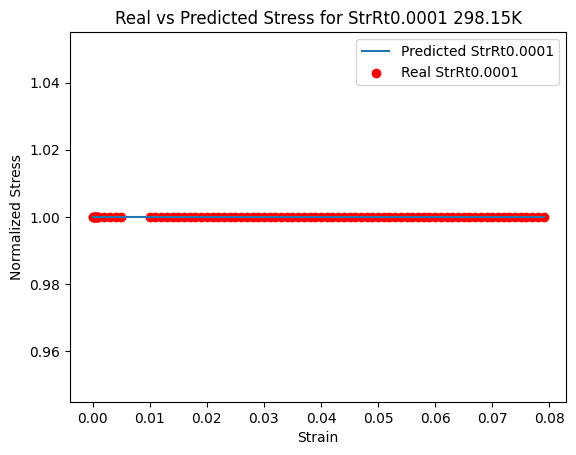

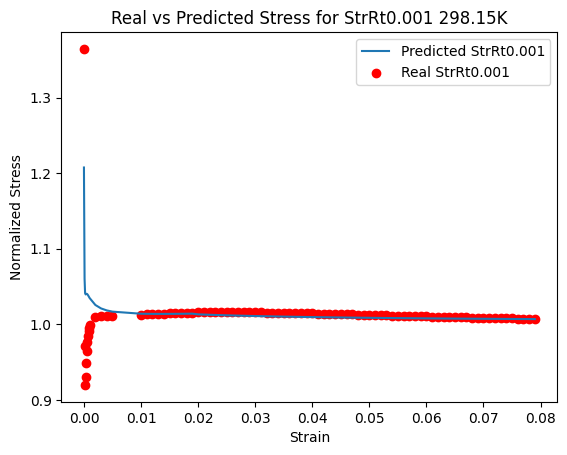

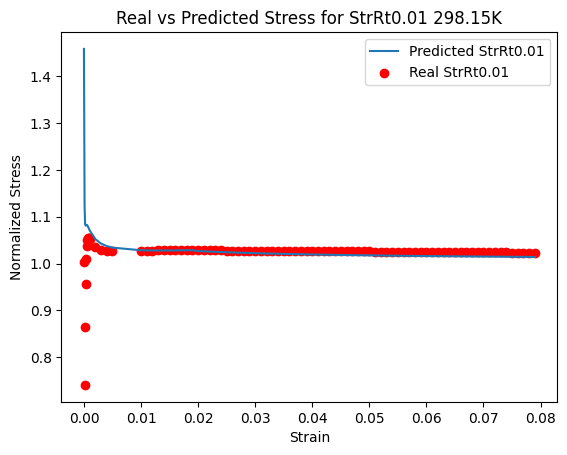

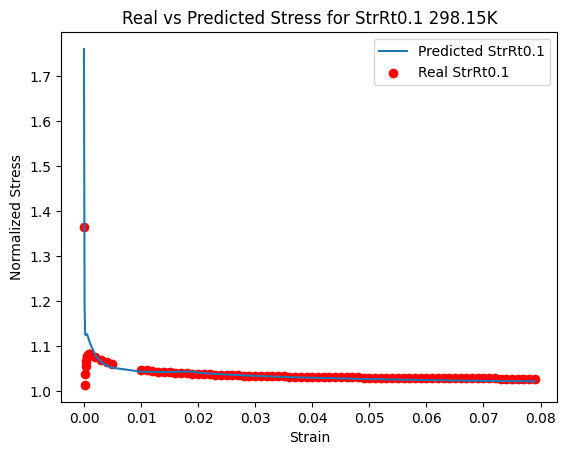

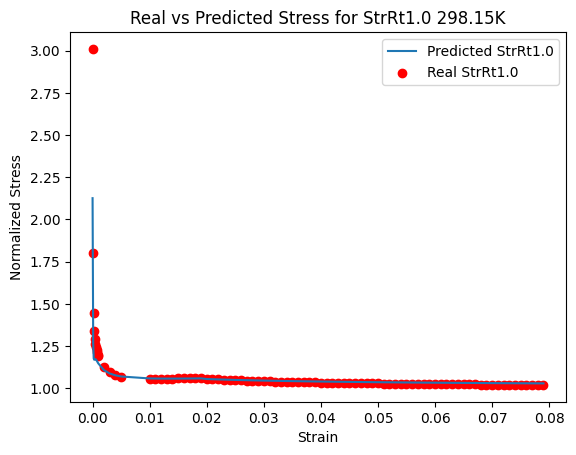

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


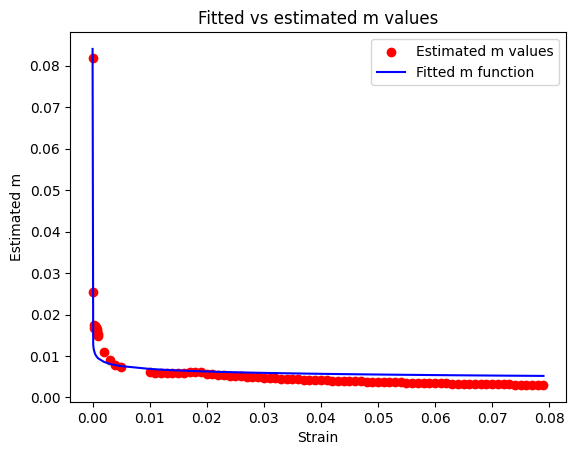

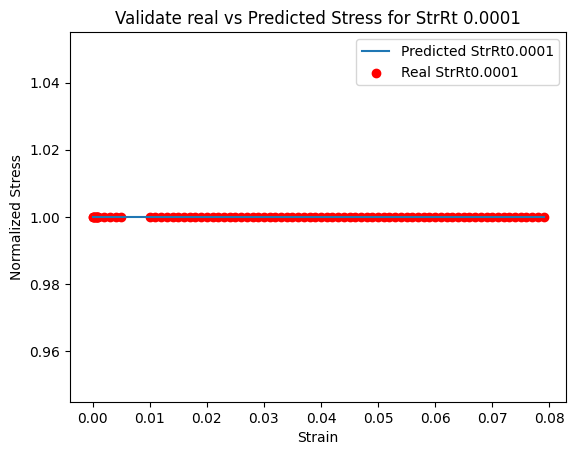

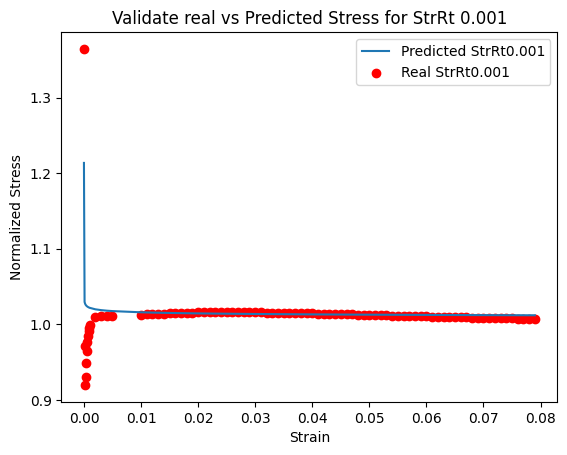

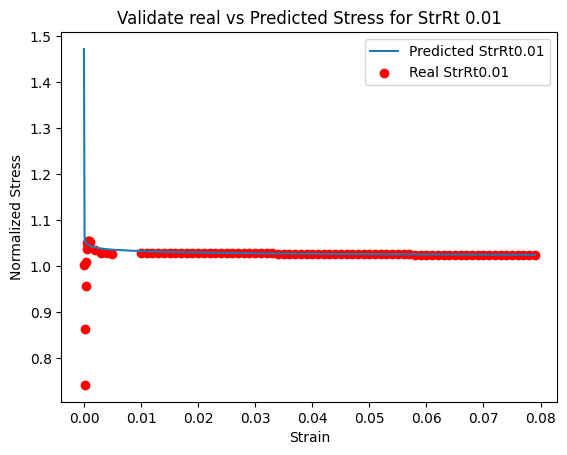

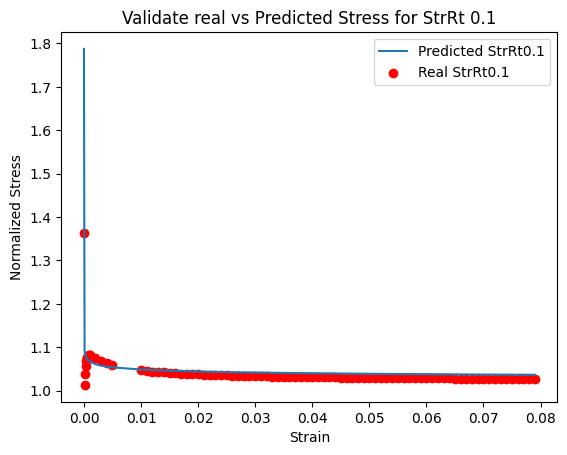

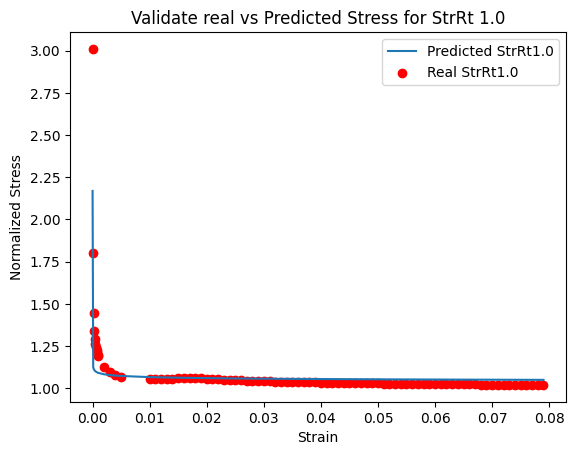

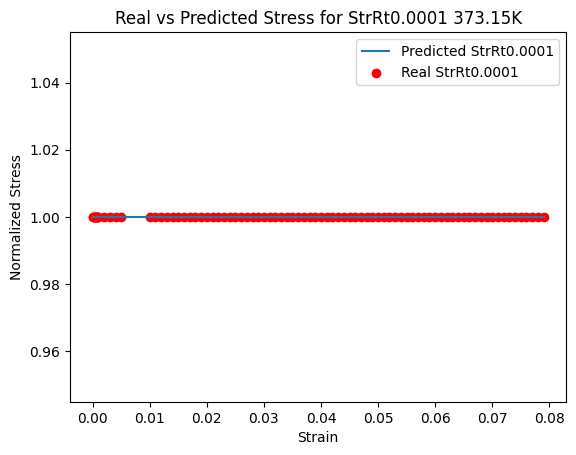

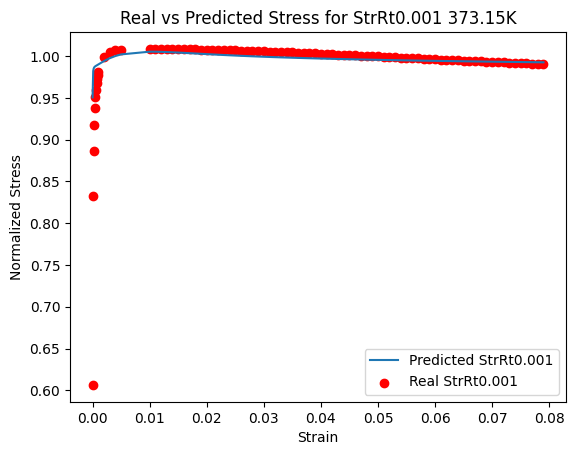

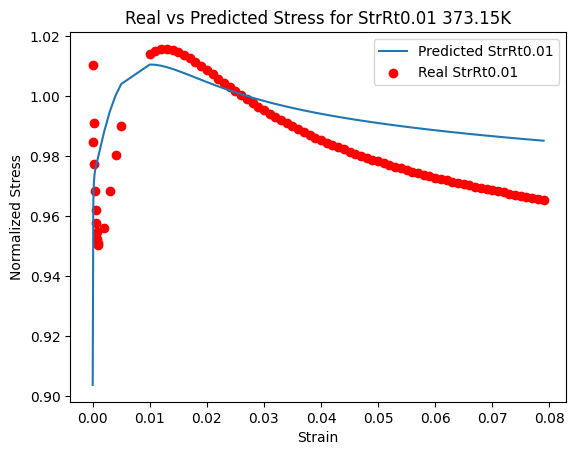

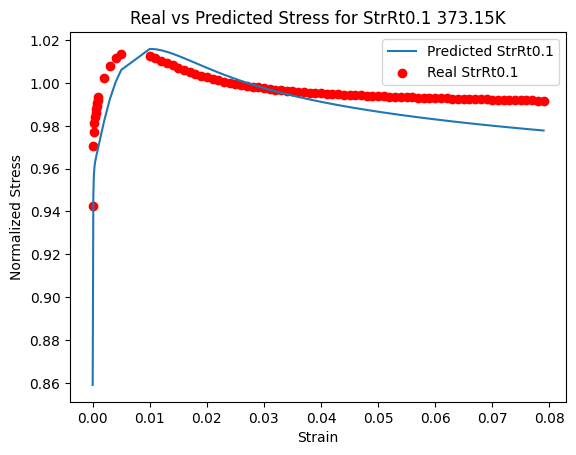

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


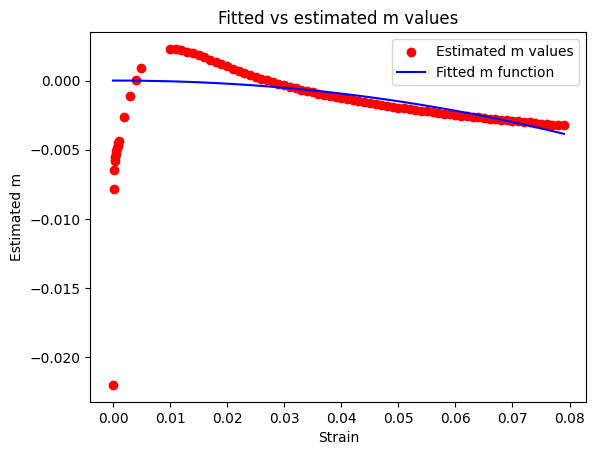

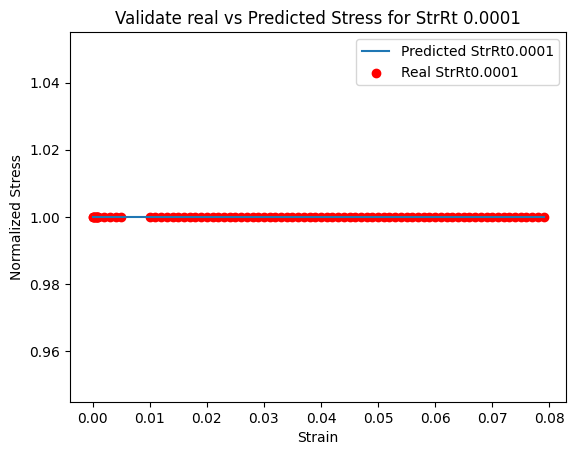

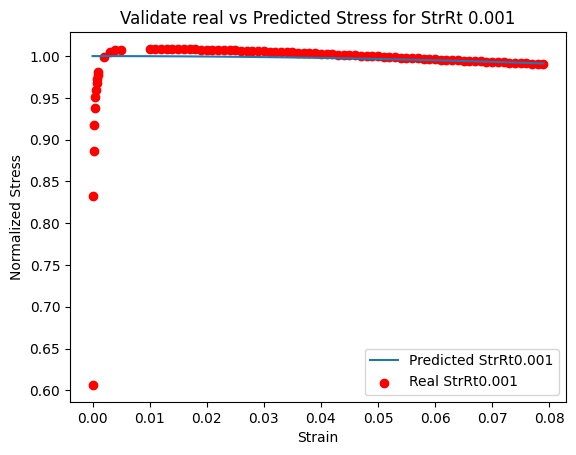

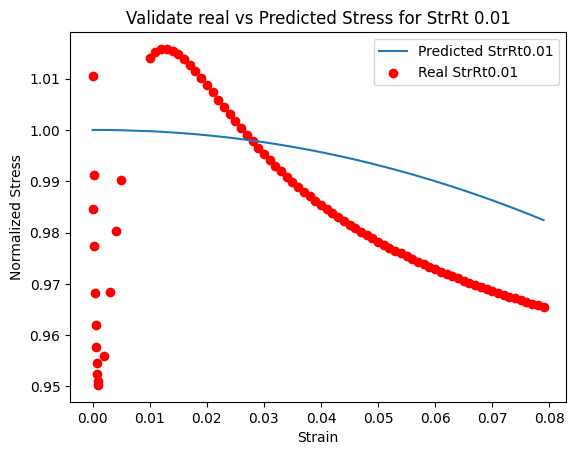

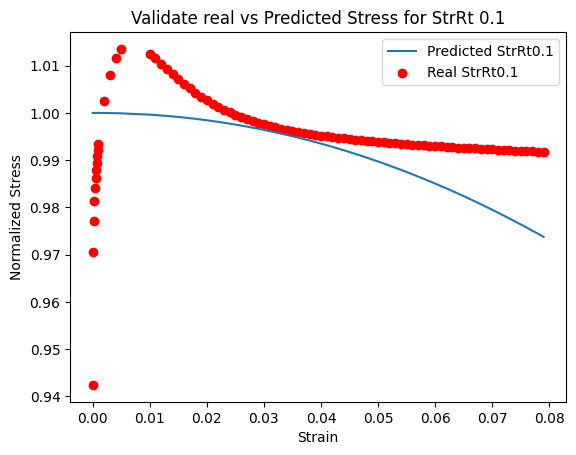

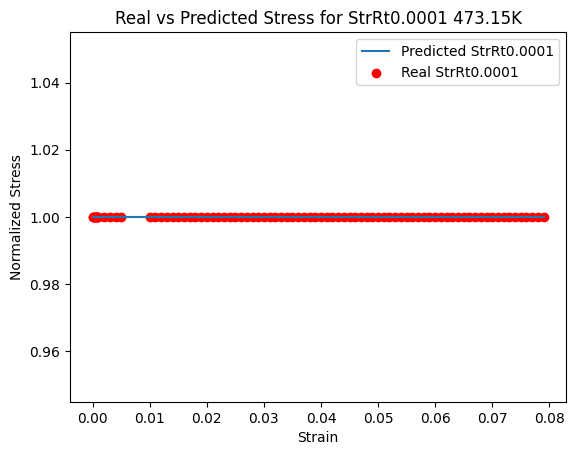

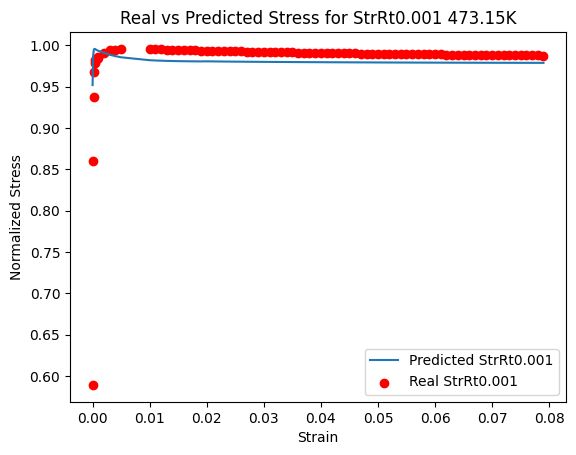

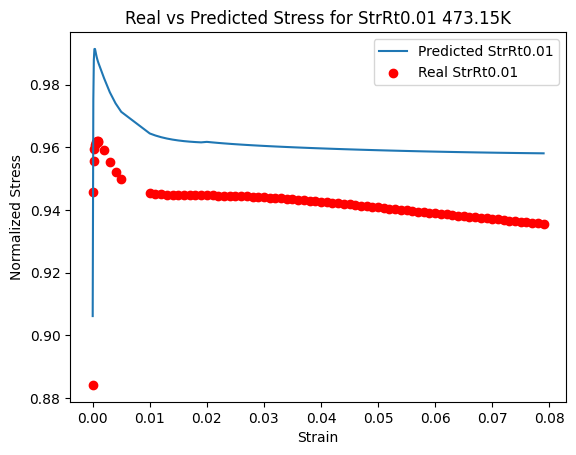

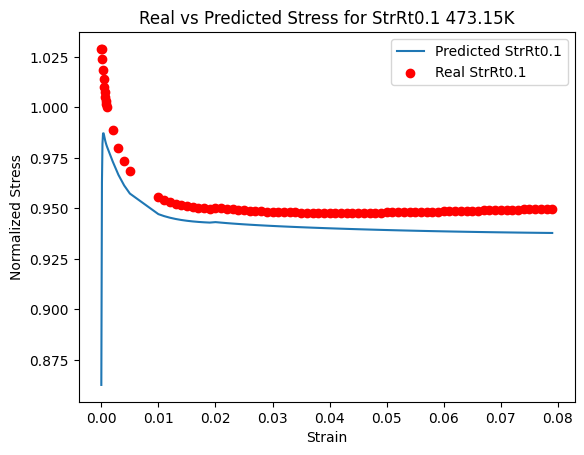

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


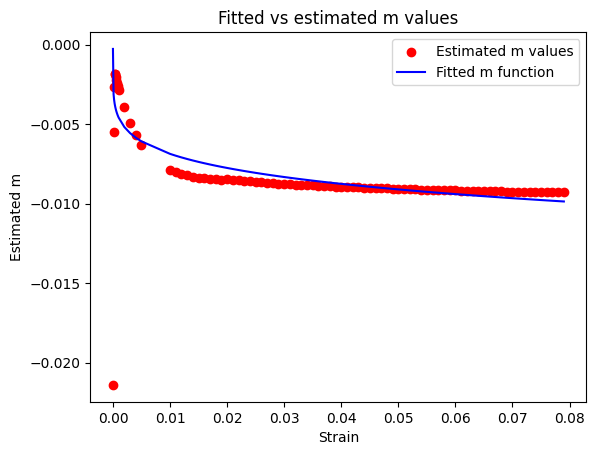

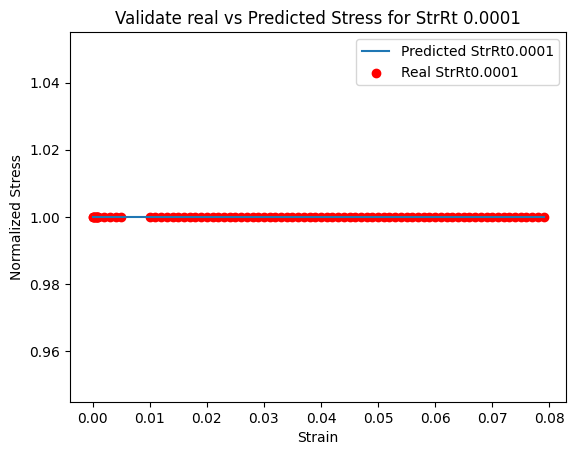

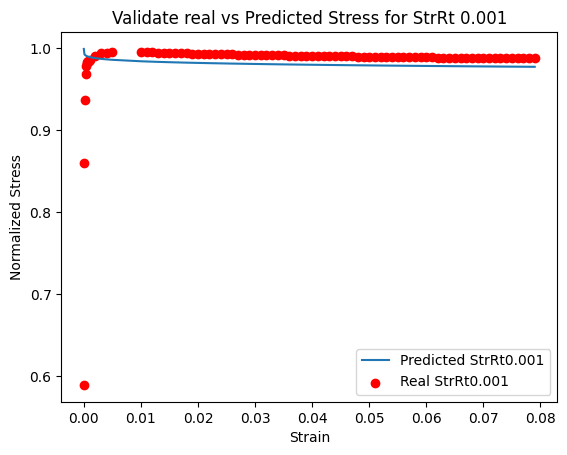

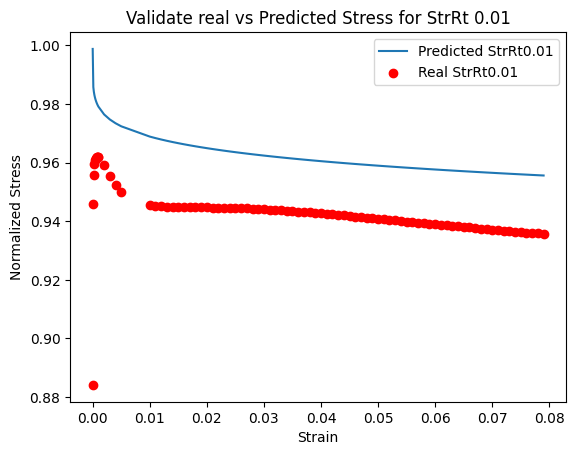

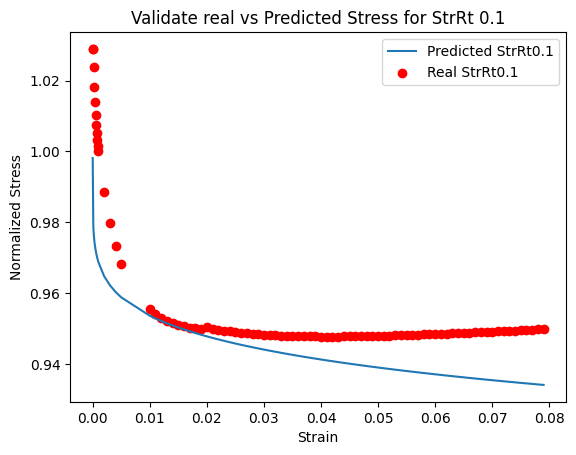

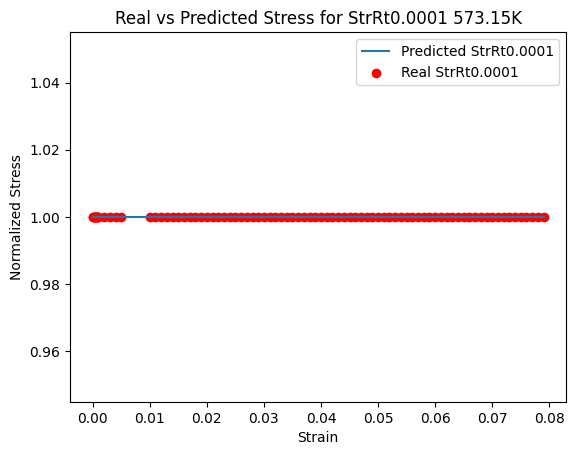

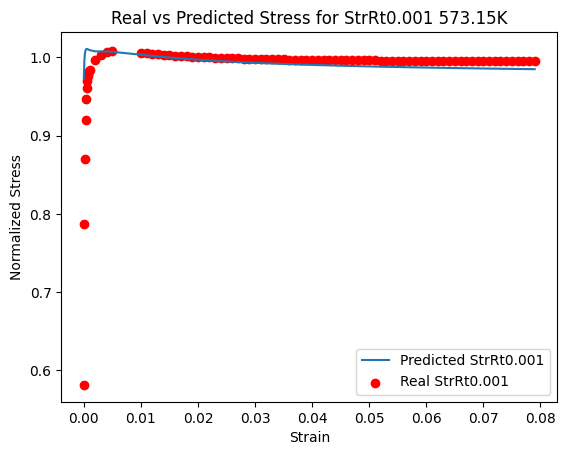

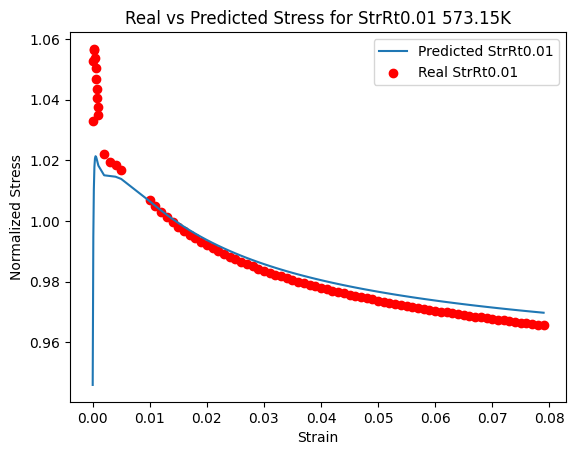

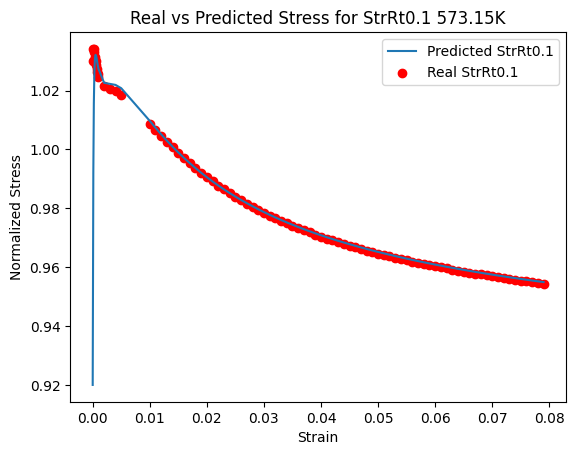

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


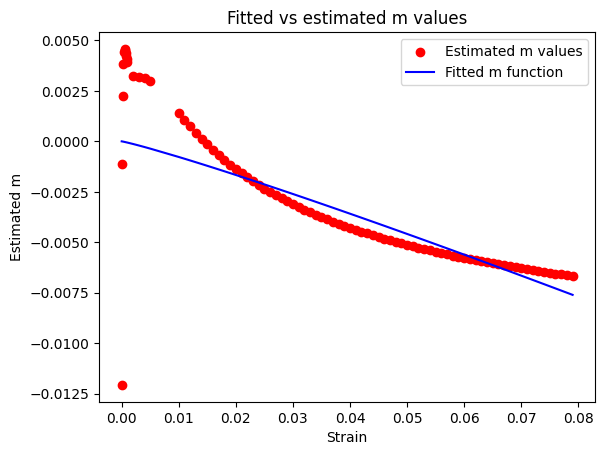

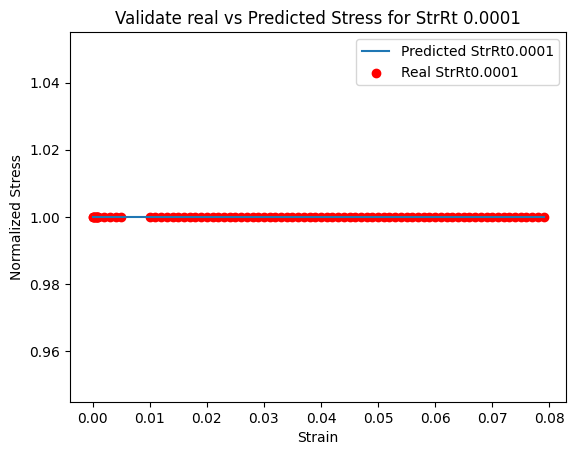

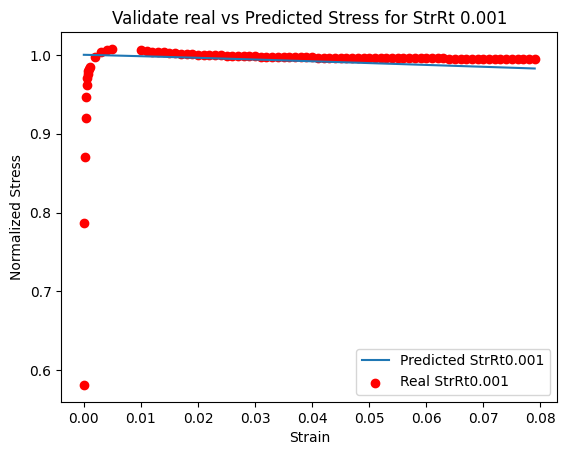

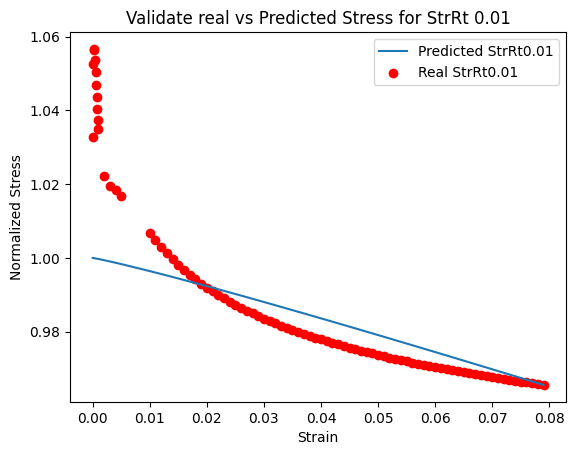

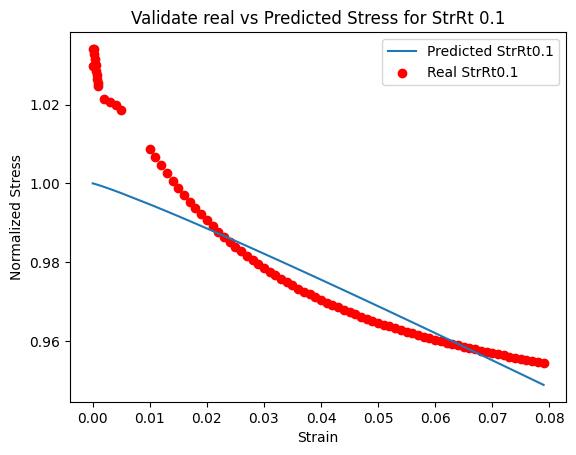

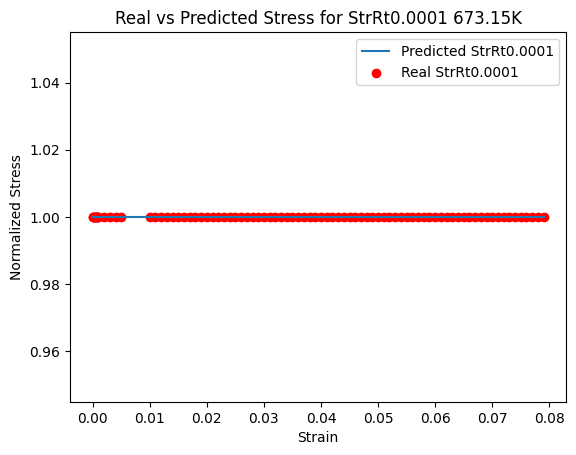

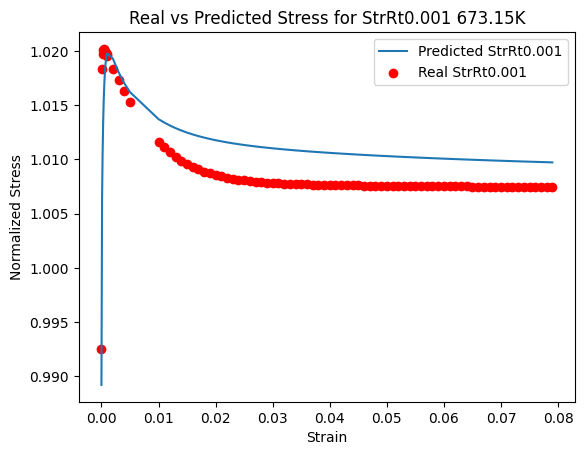

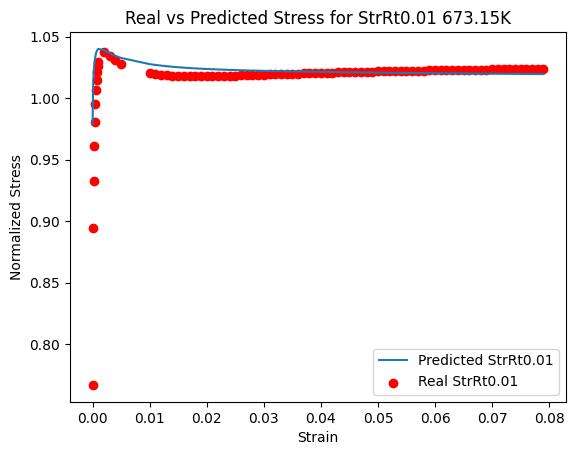

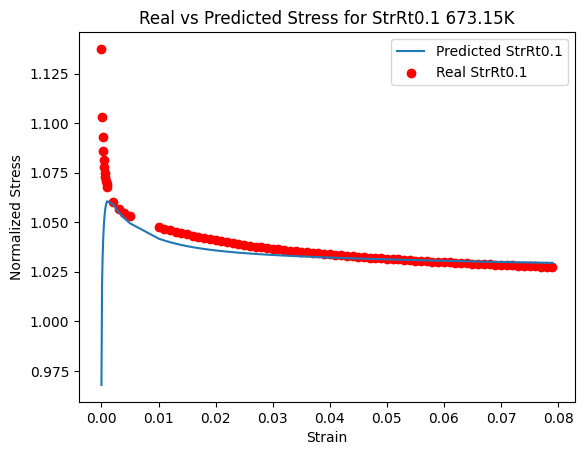

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


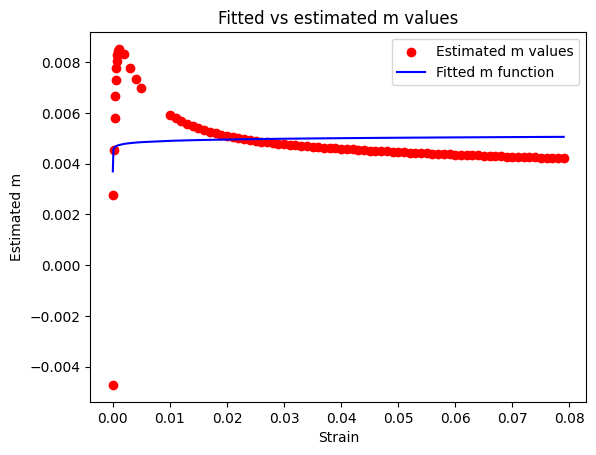

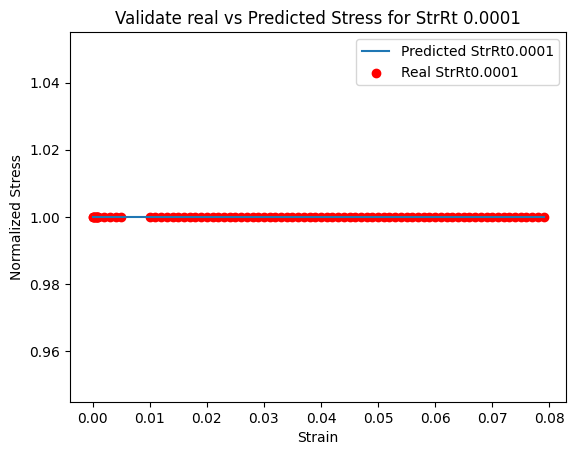

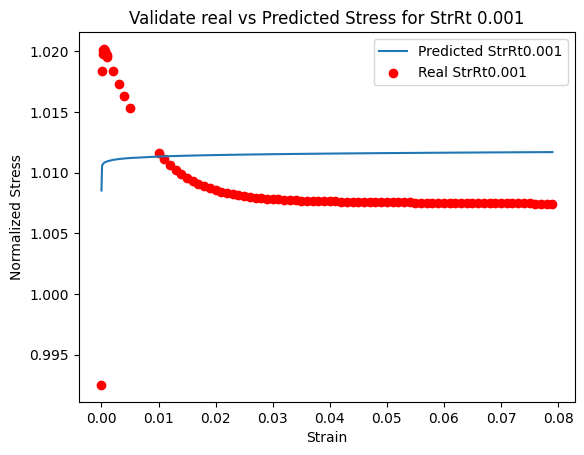

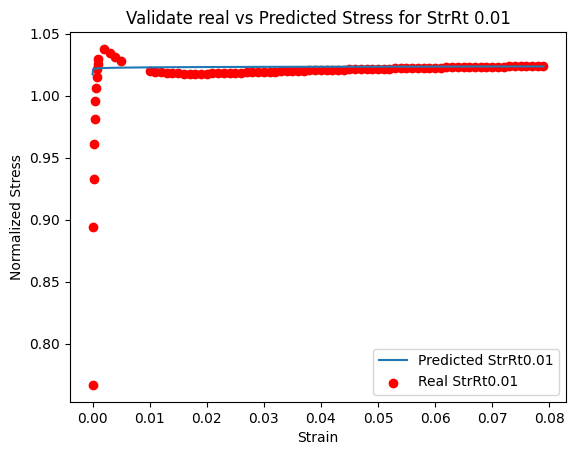

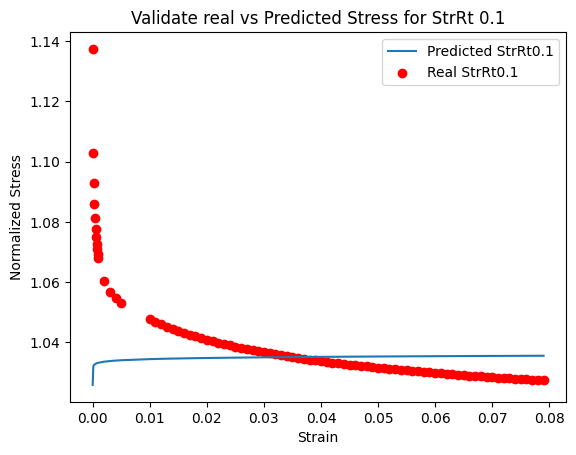

In [8]:
temp = '298.15'
strain_rates = np.array([0.0001, 0.001, 0.01, 0.1, 1])
strain_rate_columns = ['ref_StrRt0.0001', 'ref_StrRt0.001', 'ref_StrRt0.01', 'ref_StrRt0.1', 'ref_StrRt1']

data = pd.read_csv(f"../Tmp{temp}_RD.csv")
validate_stress(fit_m_function(estimate_m_values(data, strain_rate_columns, strain_rates, temp)), data, strain_rate_columns, strain_rates)

temps = ['373.15', '473.15', '573.15', '673.15']
strain_rates = np.array([0.0001, 0.001, 0.01, 0.1])
strain_rate_columns = ['ref_StrRt0.0001', 'ref_StrRt0.001', 'ref_StrRt0.01', 'ref_StrRt0.1']

for temp in temps:
    data = pd.read_csv(f"../Tmp{temp}_RD.csv")
    validate_stress(fit_m_function(estimate_m_values(data, strain_rate_columns, strain_rates, temp)), data, strain_rate_columns, strain_rates)